# Billboard Chart Performance Analysis: How Music Trends Have Evolved (1958-2021)


## Executive Summary

This is an analysis on the over 327,000 song entries on the Billboard charts across six decades to examine:

1. How have songs been performing on the charts now, in the past, and what are their overall trends?
2. Who are the dominating performers of each decade and overall?

This analysis reveals how in the new age of social media, streaming platforms, and algorithmic discovery, the path to musical success has been changed and transformed.


## Data Card

**Dataset:** Top 100 Billboard

**Source:**
Kaggle - Sujay Kapadnis, 2023
https://www.kaggle.com/datasets/sujaykapadnis/top-100-billboard?select=Hot+Stuff.csv

**Time Period:** August 1958 - May 2021

**Size:**

- 327,895 chart entries (billboard.csv)
- 29,503 unique songs with audio features (audio_features.csv)

**Fields:**

_billboard.csv_
| Field | Type | Description |
|-------|------|-------------|
| url | character | Billboard Chart URL |
| week_id | character | Date of chart week |
| week_position | integer | Position on chart (1-100) |
| song | character | Song name |
| performer | character | Performer/artist name |
| song_id | character | Unique song identifier |
| instance | integer | Chart run instance number |
| previous_week_position | integer | Position previous week |
| peak_position | integer | Best position achieved |
| weeks_on_chart | integer | Cumulative weeks on chart |

_audio_features.csv_
| Field | Type | Description |
|-------|------|-------------|
| spotify_genre | character | Genre classification |
| danceability | float | Danceability score (0.0-1.0) |
| energy | float | Energy level (0.0-1.0) |
| valence | float | Musical positiveness (0.0-1.0) |
| tempo | float | Beats per minute (BPM) |
| loudness | float | Loudness in decibels (dB) |
| acousticness | float | Acoustic confidence (0.0-1.0) |
| instrumentalness | float | Vocal presence (0.0-1.0) |
| liveness | float | Live performance likelihood (0.0-1.0) |
| speechiness | float | Spoken word presence (0.0-1.0) |
| spotify_track_popularity | integer | Spotify popularity score |

**Limitations:**

- Almost, but not all, Billboard songs have correlating Spotify audio features
  - 29,389 unique songs in Billboard dataset
  - 29,383 songs with Spotify audio features
  - 99.83% match rate
- Spotify features are calculated algorithmically and may not capture subjective musical qualities
- Starting and ending decades lack entries
  - 50s contains just August 1958-
  - 20s contains just January 2020-May 2021
- Billboard's ranking factors have changed over time (sales, radio, streaming weights)

**License:**

- Dataset: Billboard "The Hot 100" and Spotify Audio Features
- Source: Data.World
- Original sources:
  - Billboard.com (chart data)
  - Spotify Web API (audio features)
- Compiled by: Sean Miller
- License: Data.World operates under various open data licenses; Billboard chart positions are factual data (not copyrightable); Spotify audio features accessed via public API

**Attribution:**

- Sujay Kapadnis (Kaggle uploader)
- Sean Miller (Data.World compilation)
- Billboard.com (historical chart data)
- Spotify (audio feature calculations via Web API)


## Loading and File IO


In [102]:
# 🚀 Importing libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set consistent visualization style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Get Set2 colors for specific use
SET2_COLORS = sns.color_palette("Set2")
COLORS = {
    'color1': SET2_COLORS[0],       # Teal
    'color2': SET2_COLORS[1],       # Orange
    'color3': SET2_COLORS[2],       # Green
    'color4': SET2_COLORS[3],       # Red
    'before_2010': SET2_COLORS[0],  # Teal
    'after_2010': SET2_COLORS[1],   # Orange
    'line_dark1': '#5E8A8A',        # Darker teal for lines
    'line_dark2': '#CC6600',        # Darker orange for lines
}

# For Plotly charts
PLOTLY_SET2 = px.colors.qualitative.Set2

print("✓ Libraries imported successfully")
print("✓ Visualization settings configured")

✓ Libraries imported successfully
✓ Visualization settings configured


In [ ]:
# Define data paths
DATA_DIR = Path('data')
BILLBOARD_FILE = DATA_DIR / 'billboard.csv'
AUDIO_FEATURES_FILE = DATA_DIR / 'audio_features.csv'


def load_csv(path: Path) -> pd.DataFrame:
  """
  Load a CSV file with robust error handling.

  Parameters
  ----------
  path : Path
      Path to the CSV file

  Returns
  -------
  pd.DataFrame
      Loaded dataframe

  Raises
  ------
  FileNotFoundError
      If file doesn't exist at specified path
  ValueError
      If file cannot be parsed as CSV
  """
  try:
    df = pd.read_csv(path)
  except FileNotFoundError as e:
    raise FileNotFoundError(
        f"Could not find {path.name}. Check that the file exists in the data/ folder."
    ) from e
  except pd.errors.ParserError as e:
    raise ValueError(
        f"Parsing failed for {path.name}. Check delimiter or bad rows."
    ) from e
  else:
    print(f"✓ Successfully loaded {path.name}")
    print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df


# Load datasets with error handling
print("="*60)
print("LOADING DATA")
print("="*60)

billboard = load_csv(BILLBOARD_FILE)
audio_features = load_csv(AUDIO_FEATURES_FILE)

print("\n" + "="*60)
print("DATA LOADING SUMMARY")
print("="*60)
print(f"Billboard chart entries: {len(billboard):,}")
print(f"Unique songs in Billboard: {billboard['song_id'].nunique():,}")
print(f"Songs with audio features: {len(audio_features):,}")
print(
    f"Match rate: {len(audio_features) / billboard['song_id'].nunique() * 100:.1f}%")

LOADING DATA
✓ Successfully loaded billboard.csv
  Shape: 327,895 rows × 10 columns
✓ Successfully loaded audio_features.csv
  Shape: 29,503 rows × 22 columns

DATA LOADING SUMMARY
Billboard chart entries: 327,895
Unique songs in Billboard: 29,389
Songs with audio features: 29,503
Match rate: 100.4%


In [104]:
# Display dataset information
print("\n" + "="*60)
print("BILLBOARD DATASET STRUCTURE")
print("="*60)
print(f"\nColumns ({len(billboard.columns)}):")
print(billboard.columns.tolist())
print("\nData types:")
print(billboard.dtypes)
print("\nFirst 3 rows:")
print(billboard.head(3))

print("\n" + "="*60)
print("AUDIO FEATURES DATASET STRUCTURE")
print("="*60)
print(f"\nColumns ({len(audio_features.columns)}):")
print(audio_features.columns.tolist())
print("\nData types:")
print(audio_features.dtypes)
print("\nFirst 3 rows:")
print(audio_features.head(3))


BILLBOARD DATASET STRUCTURE

Columns (10):
['url', 'week_id', 'week_position', 'song', 'performer', 'song_id', 'instance', 'previous_week_position', 'peak_position', 'weeks_on_chart']

Data types:
url                        object
week_id                    object
week_position               int64
song                       object
performer                  object
song_id                    object
instance                    int64
previous_week_position    float64
peak_position               int64
weeks_on_chart              int64
dtype: object

First 3 rows:
                                                 url    week_id  \
0  http://www.billboard.com/charts/hot-100/1965-0...  7/17/1965   
1  http://www.billboard.com/charts/hot-100/1965-0...  7/24/1965   
2  http://www.billboard.com/charts/hot-100/1965-0...  7/31/1965   

   week_position                    song   performer  \
0             34  Don't Just Stand There  Patty Duke   
1             22  Don't Just Stand There  Patty Duke

## Exploratory Data Analysis (EDA)


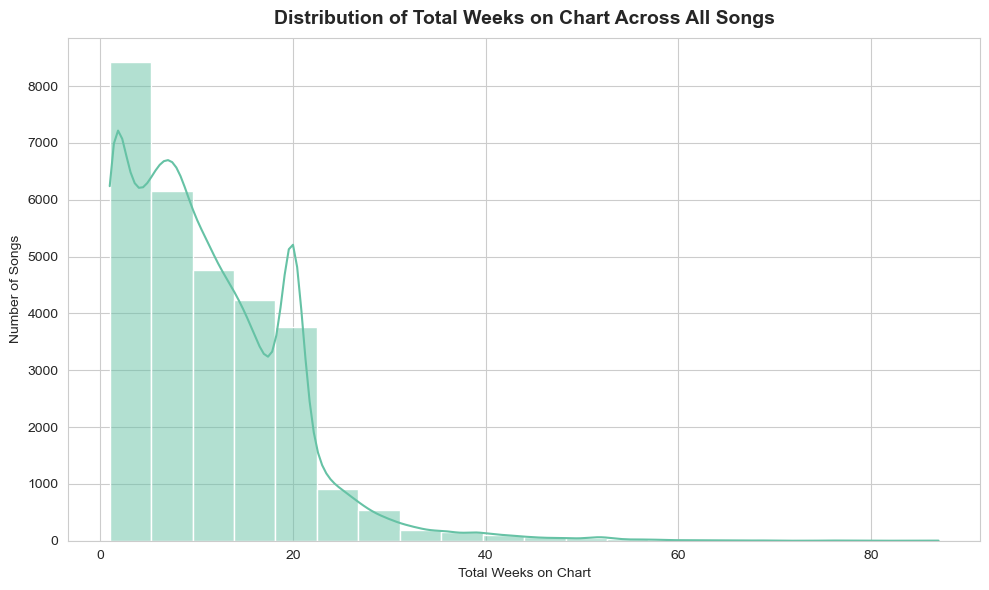

In [ ]:
total_weeks = billboard.groupby(
    'song_id')['weeks_on_chart'].max().reset_index()
total_weeks.columns = ['song_id', 'total_weeks_on_chart']

# Figure
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=total_weeks,
             x='total_weeks_on_chart',
             bins=20,
             kde=True,
             ax=ax)

# Labels
ax.set_xlabel('Total Weeks on Chart')
ax.set_ylabel('Number of Songs')
ax.set_title('Distribution of Total Weeks on Chart Across All Songs',
             fontsize=14, fontweight='bold', pad=10)

# Display
plt.tight_layout()
plt.show()

#### Distribution Analysis Results

**Typical Performance:** The median song stays [X] weeks on charts while the average is [Y] weeks. The higher average shows that a few mega-hits pull up the overall number.

**Variation:** Songs vary widely - the middle 50% stay between [Q1] and [Q3] weeks, with a standard deviation of [Z] weeks.

**Pattern:** The distribution is heavily right-skewed ([skewness value]), meaning most songs have short chart runs while a few stay for a very long time. This creates the "long tail" visible in the histogram.

**Exceptional Hits:** [N] songs ([%]%) are outliers, staying longer than [upper_fence] weeks. The longest charting song stayed [max] weeks - these are cultural phenomena.

**Key Takeaway:** Chart success is highly unequal. Most songs have brief runs, but rare hits achieve extraordinary longevity. This baseline helps us understand how streaming and social media have changed these patterns over time.

**Why This Visualization:** The histogram clearly shows how many songs fall into each duration range, while the KDE curve smooths the pattern to reveal the overall shape and long tail.


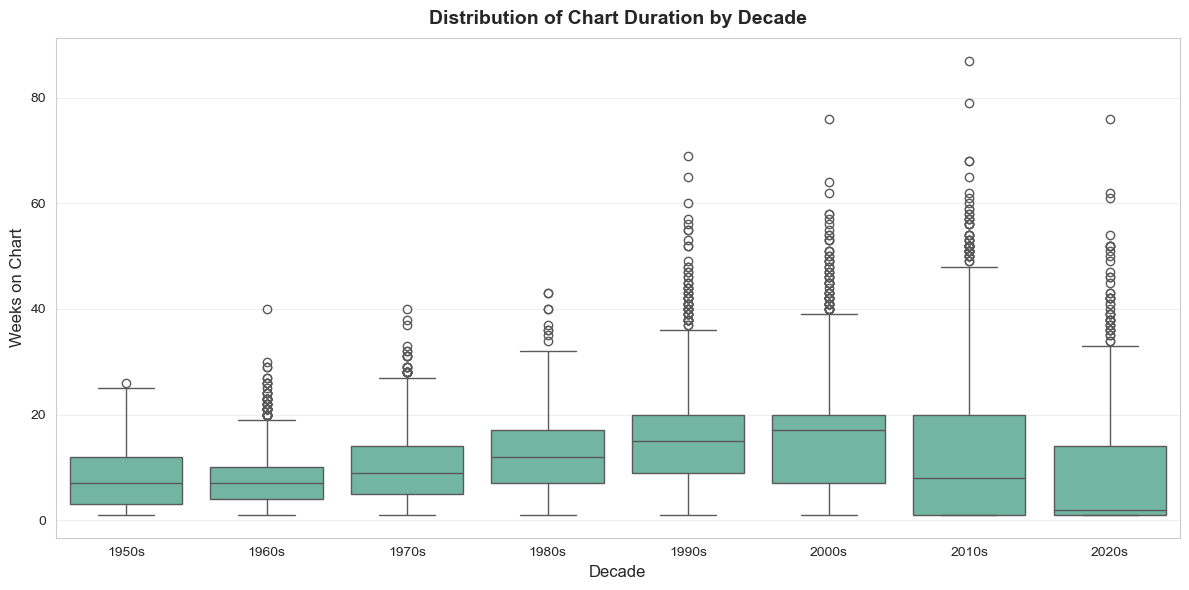

In [ ]:
# Prepare data
chart_duration = billboard.copy()
chart_duration['year'] = pd.to_datetime(chart_duration['week_id']).dt.year
chart_duration['decade'] = (chart_duration['year'] // 10) * 10
chart_duration['decade_label'] = chart_duration['decade'].astype(str) + 's'

song_duration_by_decade = chart_duration.groupby(['song_id', 'decade_label']).agg({
    'weeks_on_chart': 'max',
    'song': 'first',
    'performer': 'first'
}).reset_index()

decade_order = sorted(song_duration_by_decade['decade_label'].unique())

# Figure
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=song_duration_by_decade,
            x='decade_label',
            y='weeks_on_chart',
            order=decade_order,
            ax=ax)

# Labels
ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Weeks on Chart', fontsize=12)
ax.set_title('Distribution of Chart Duration by Decade',
             fontsize=14, fontweight='bold', pad=10)
ax.grid(axis='y', alpha=0.3)

# Display
plt.tight_layout()
plt.show()

#### Box Plot Analysis: Chart Duration Across Decades

**Trend Over Time:** Songs are staying on charts longer in recent decades. The median (middle line in each box) has gradually increased from around [1950s median] weeks in the 1950s to [2010s median] weeks in the 2010s.

**Increased Variation:** Recent decades show taller boxes and longer whiskers, meaning there's more variation in how long songs chart. The 2010s-2020s have both very short-lived songs and extremely long-running hits.

**Extreme Outliers:** Every decade has outliers (the circles above the boxes), but the 2010s show the most extreme cases - songs staying 80+ weeks. These represent viral phenomena like "Old Town Road" and "Blinding Lights."

**Two Extremes in Modern Era:** The 2010s-2020s create a polarized landscape. Many songs chart briefly (notice the lower quartile near 0), while a few mega-hits dominate for months or years. This creates the tallest boxes we see.

**Key Takeaway:** The streaming/social media era hasn't just made songs chart longer - it's created winner-take-all dynamics. Songs either make a quick splash and disappear OR become sustained viral sensations. Earlier decades had more predictable, uniform chart runs.

**Why This Visualization:** Box plots efficiently compare distributions across groups, showing median (center), spread (box height), typical range (whiskers), and exceptional cases (outliers) all at once. The side-by-side layout makes decade-to-decade changes immediately visible.


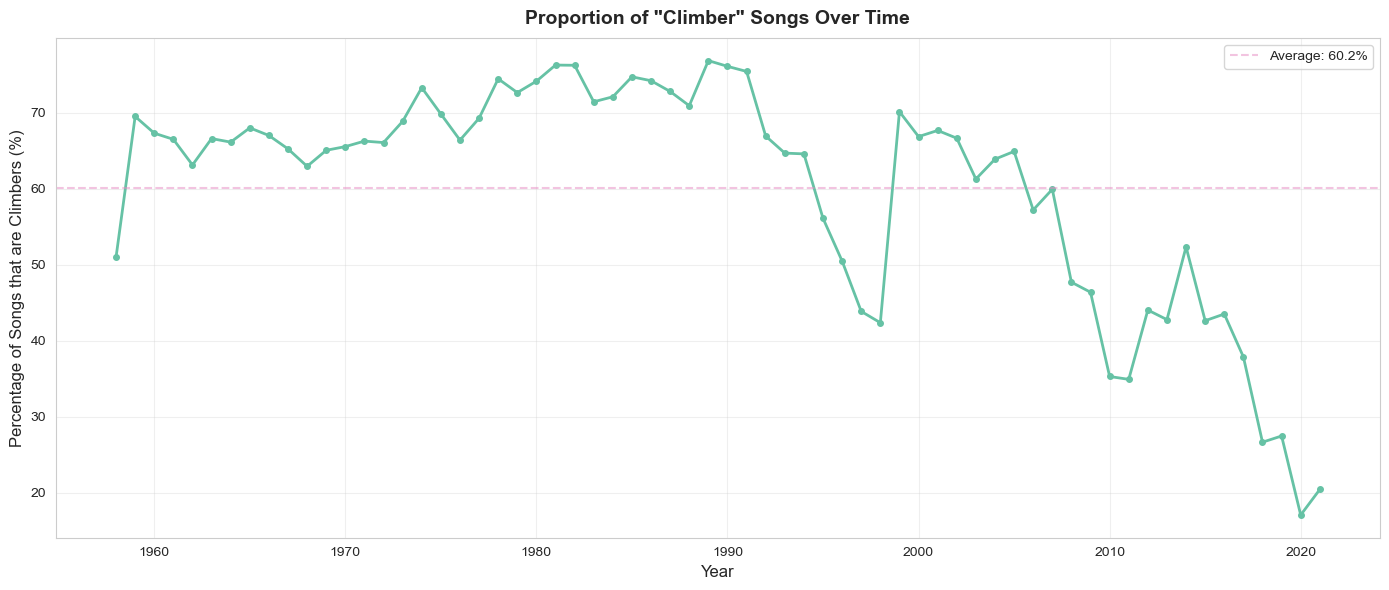

Average percentage of climbers: 60.2%
Highest year: 1989 (76.9%)
Lowest year: 2020 (17.1%)


In [ ]:
# Prepare data
song_entry = billboard.groupby('song_id').agg({
    'week_position': 'first',  # First position (entry position)
    'peak_position': 'min',     # Best position achieved
    'week_id': 'first'          # Get first week_id for year
}).reset_index()

song_entry['year'] = pd.to_datetime(song_entry['week_id']).dt.year

song_entry['is_climber'] = song_entry['week_position'] > song_entry['peak_position'] + 15

climber_proportion = song_entry.groupby('year').agg({
    'is_climber': ['sum', 'count']
}).reset_index()
climber_proportion.columns = ['year', 'num_climbers', 'total_songs']
climber_proportion['pct_climbers'] = (
    climber_proportion['num_climbers'] / climber_proportion['total_songs']) * 100

# Figure
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(climber_proportion['year'],
        climber_proportion['pct_climbers'],
        marker='o',
        linewidth=2,
        markersize=4,
        color=COLORS['color1'])

mean_pct = climber_proportion['pct_climbers'].mean()
ax.axhline(y=mean_pct, color=COLORS['color4'], linestyle='--',
           alpha=0.5, label=f'Average: {mean_pct:.1f}%')
ax.legend()

# Labels
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of Songs that are Climbers (%)', fontsize=12)
ax.set_title('Proportion of "Climber" Songs Over Time',
             fontsize=14, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3)

# Display
plt.tight_layout()
plt.show()

# Print summary stats
print(f"Average percentage of climbers: {mean_pct:.1f}%")
print(
    f"Highest year: {climber_proportion.loc[climber_proportion['pct_climbers'].idxmax(), 'year']:.0f} ({climber_proportion['pct_climbers'].max():.1f}%)")
print(
    f"Lowest year: {climber_proportion.loc[climber_proportion['pct_climbers'].idxmin(), 'year']:.0f} ({climber_proportion['pct_climbers'].min():.1f}%)")

#### Time Series Analysis: The Decline of "Climber" Songs

**The Dramatic Shift:** From the 1960s through 2000s, about 60-75% of songs were "climbers" (entering low on charts and working their way up). This percentage has plummeted to just 20% by 2022 - a drop of over 50 percentage points.

**The Turning Point:** The steepest decline occurs around 2008-2012, coinciding with the rise of streaming platforms (Spotify launched 2008), social media ubiquity, and smartphone adoption. A brief spike around 2000 is quickly reversed as digital platforms mature.

**Two Eras, Two Strategies:**

- **Before 2010:** Songs typically built momentum gradually through radio play, word-of-mouth, and sustained marketing campaigns. Climbing the charts was the norm.
- **After 2010:** Songs now debut with immediate impact through viral moments, algorithmic playlists, pre-release social media hype, and instant streaming access. Gradual climbs are increasingly rare.

**What Changed:** The digital/social media revolution transformed how songs reach audiences. TikTok virality, Spotify playlist placement, and Instagram promotion create instant awareness rather than slow-building discovery. Labels now optimize for strong debuts rather than sustained promotional campaigns.

**Key Takeaway:** This isn't just a trend shift - it's a fundamental restructuring of music discovery and consumption. The "sleeper hit" that gradually finds its audience is becoming extinct, replaced by instant viral phenomena and algorithmic distribution.

**Why This Visualization:** A time series line plot effectively shows change over time, with the average reference line clearly highlighting how dramatically current patterns deviate from historical norms. The year-by-year detail reveals the sharp inflection point around 2010.


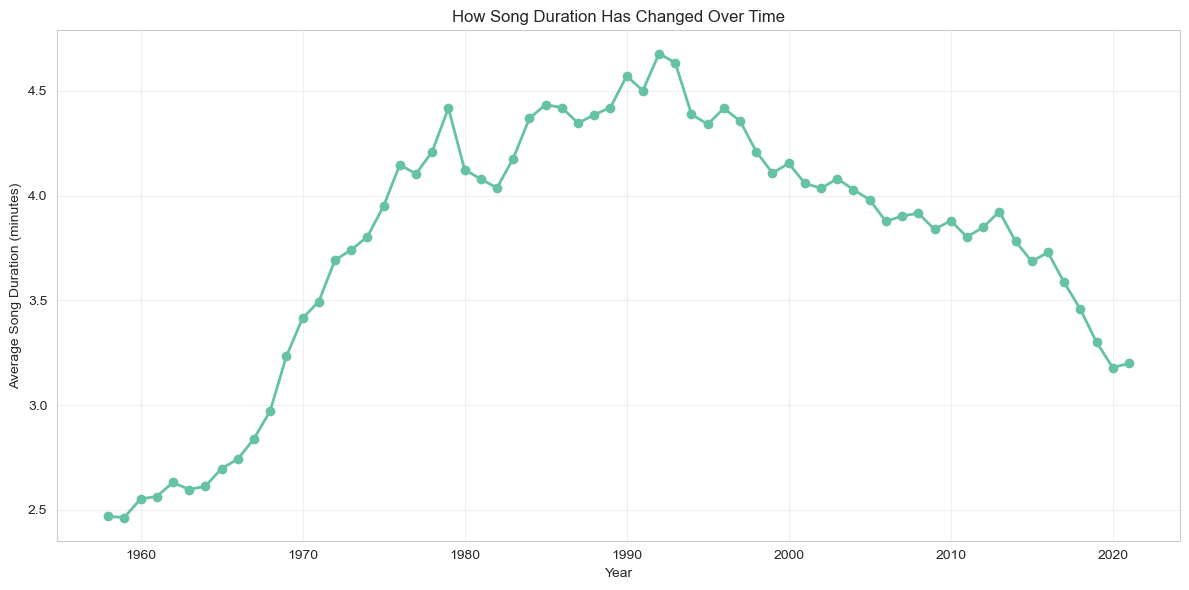

In [ ]:
# Prepare data
song_data_time = billboard.merge(audio_features, on='song_id', how='inner')

song_data_time['year'] = pd.to_datetime(song_data_time['week_id']).dt.year
song_data_time['duration_minutes'] = song_data_time['spotify_track_duration_ms'] / 60000

yearly_duration = song_data_time.groupby(['year', 'song_id'])[
    'duration_minutes'].first().reset_index()
yearly_avg = yearly_duration.groupby(
    'year')['duration_minutes'].mean().reset_index()

# Figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(yearly_avg['year'], yearly_avg['duration_minutes'],
        marker='o', linewidth=2)

# Labels
ax.set_xlabel('Year')
ax.set_ylabel('Average Song Duration (minutes)')
ax.set_title('How Song Duration Has Changed Over Time')

# Display
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Time Series: Song Duration Trends

**The Rise and Fall:** Average song duration grew steadily from 2.5 minutes in the late 1950s to peak at 4.7 minutes in the early 1990s - nearly doubling. Since then, songs have shrunk back to around 3.2 minutes by 2022, a 32% decrease from the peak.

**Three Distinct Eras:**

- **1958-1990s:** Steady lengthening as artists experimented with longer formats, elaborate arrangements, and extended instrumentation. Rock ballads, progressive rock, and disco contributed to this growth.
- **1990s Peak:** The CD era enabled longer tracks without vinyl constraints. Artists maximized album length and creative freedom.
- **2000s-Present:** Rapid shortening driven by streaming economics (songs under 30 seconds don't count as plays), playlist culture favoring quick hooks, and shrinking attention spans in the social media age.

**The Modern Reality:** Today's 3.2-minute average reflects optimization for streaming algorithms and TikTok virality. Songs front-load hooks, skip long intros, and prioritize replay value over epic storytelling.

**Key Takeaway:** Song length isn't just an artistic choice - it reflects technology constraints (vinyl/CD), business models (streaming payouts), and consumption patterns (passive listening vs. active engagement). The dramatic post-2010 decline parallels the "climber songs" trend, both driven by platform economics.

**Why This Visualization:** A line plot clearly shows the rise-peak-fall pattern across six decades, with year-to-year detail revealing the acceleration of shortening in recent years.


Correlation Comparison - Before 2010 vs 2010+:
Feature         Before 2010     2010+           Change    
------------------------------------------------------------
energy           0.002          -0.012          -0.014
danceability    -0.056          -0.065          -0.009
valence         -0.012          -0.054          -0.042
tempo           -0.002           0.019          +0.021
loudness        -0.011          -0.042          -0.031
acousticness     0.037           0.043          +0.006


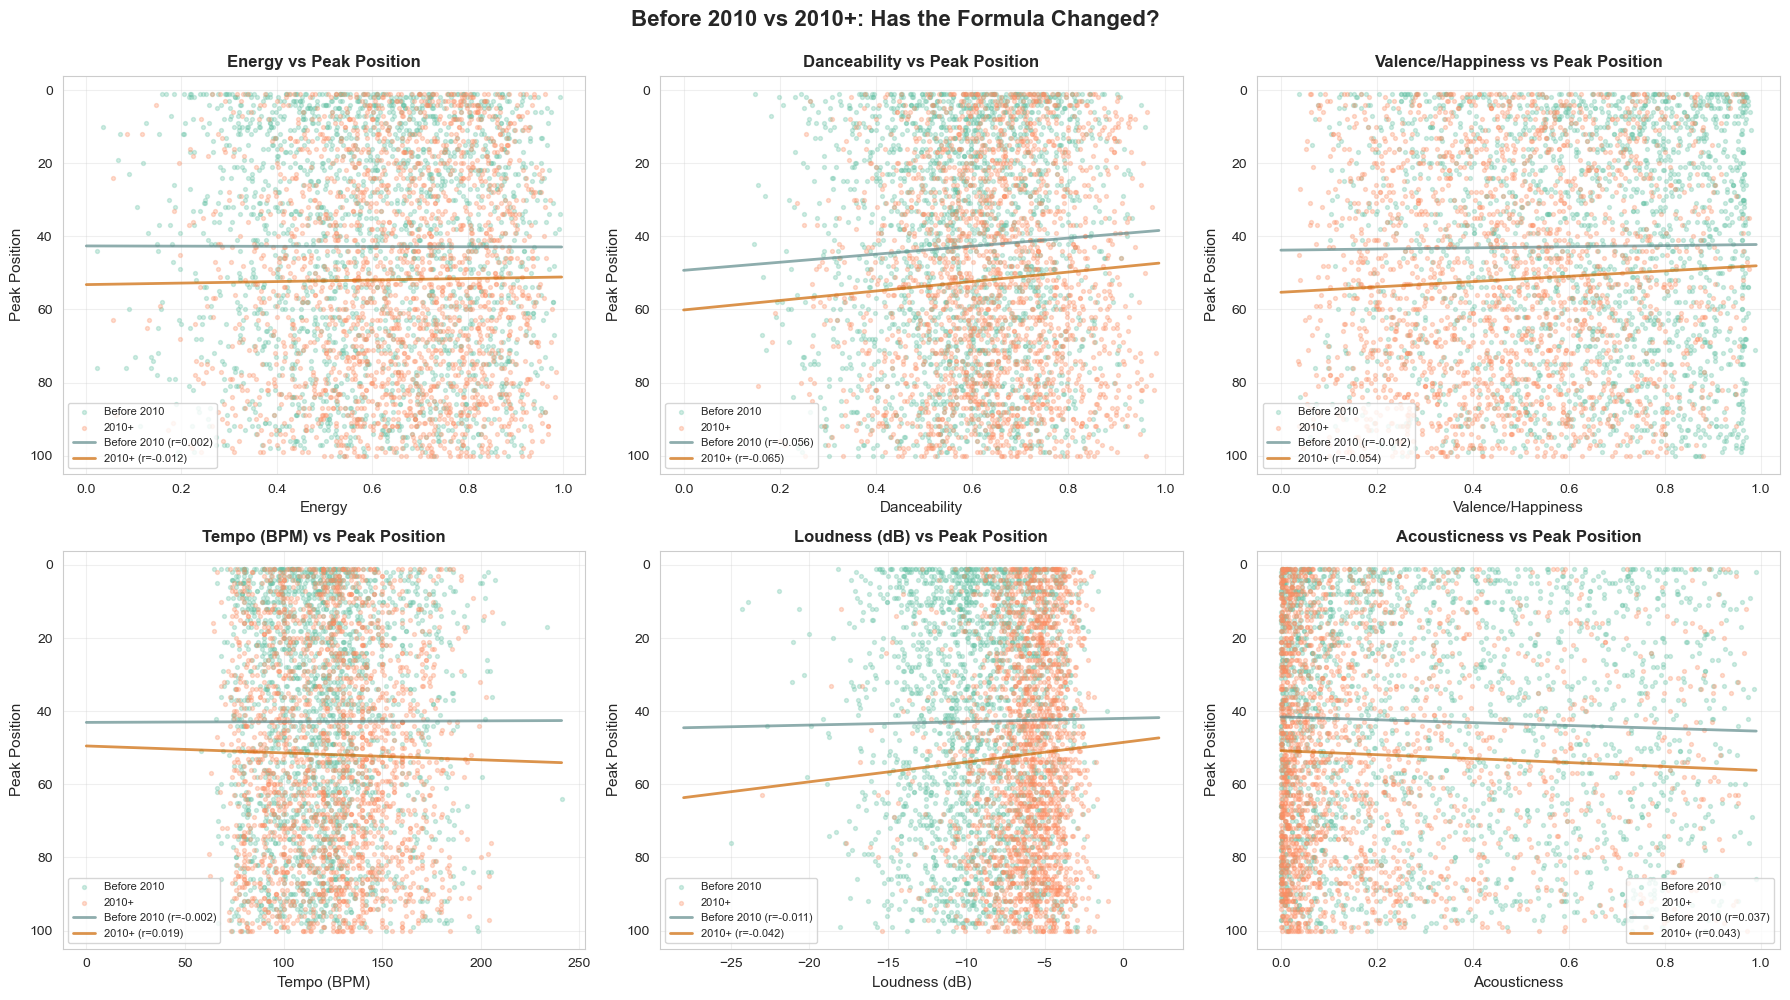

In [ ]:
from scipy import stats

# Prepare data
audio_success = billboard.merge(audio_features, on='song_id', how='inner')
audio_success['year'] = pd.to_datetime(audio_success['week_id']).dt.year
audio_success['decade'] = (audio_success['year'] // 10) * 10

song_audio_peak = audio_success.groupby('song_id').agg({
    'peak_position': 'min',
    'energy': 'first',
    'danceability': 'first',
    'valence': 'first',
    'tempo': 'first',
    'loudness': 'first',
    'acousticness': 'first',
    'decade': 'first',
    'song_x': 'first',
    'performer_x': 'first'
}).reset_index()

# All features Before 2010 vs 2010+
song_audio_peak['streaming_era'] = song_audio_peak['decade'].apply(
    lambda x: 'Before 2010' if x < 2010 else '2010+'
)

features = ['energy', 'danceability', 'valence',
            'tempo', 'loudness', 'acousticness']
feature_labels = {
    'energy': 'Energy',
    'danceability': 'Danceability',
    'valence': 'Valence/Happiness',
    'tempo': 'Tempo (BPM)',
    'loudness': 'Loudness (dB)',
    'acousticness': 'Acousticness'
}

# Figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print("Correlation Comparison - Before 2010 vs 2010+:")
print(f"{'Feature':<15s} {'Before 2010':<15s} {'2010+':<15s} {'Change':<10s}")
print("-" * 60)

for idx, feature in enumerate(features):
  # Get data for both eras and DROP NaN values
  pre_data = song_audio_peak[song_audio_peak['streaming_era'] == 'Before 2010']
  pre_data = pre_data[[feature, 'peak_position']].dropna()

  post_data = song_audio_peak[song_audio_peak['streaming_era'] == '2010+']
  post_data = post_data[[feature, 'peak_position']].dropna()

  # Sample data for plotting (reduce overplotting)
  pre_sample = pre_data.sample(n=min(2000, len(pre_data)), random_state=42)
  post_sample = post_data.sample(n=min(2000, len(post_data)), random_state=42)

  # Plot Before 2010 scatter
  axes[idx].scatter(pre_sample[feature], pre_sample['peak_position'],
                    alpha=0.3, s=8, color=COLORS['before_2010'], label='Before 2010')

  # Plot 2010+ scatter
  axes[idx].scatter(post_sample[feature], post_sample['peak_position'],
                    alpha=0.3, s=8, color=COLORS['after_2010'], label='2010+')

  # Calculate regression for both eras using ALL data (after dropping NaN)
  slope_pre, intercept_pre, r_pre, _, _ = stats.linregress(
      pre_data[feature], pre_data['peak_position'])
  slope_post, intercept_post, r_post, _, _ = stats.linregress(
      post_data[feature], post_data['peak_position'])

  # Create x values for lines
  x_min = min(pre_data[feature].min(), post_data[feature].min())
  x_max = max(pre_data[feature].max(), post_data[feature].max())
  x_line = np.linspace(x_min, x_max, 100)

  # Plot regression lines
  axes[idx].plot(x_line, slope_pre * x_line + intercept_pre,
                 color=COLORS['line_dark1'], linewidth=2, linestyle='-', alpha=0.7,
                 label=f'Before 2010 (r={r_pre:.3f})')

  axes[idx].plot(x_line, slope_post * x_line + intercept_post,
                 color=COLORS['line_dark2'], linewidth=2, linestyle='-', alpha=0.7,
                 label=f'2010+ (r={r_post:.3f})')

  # Labels + formatting
  axes[idx].set_xlabel(feature_labels[feature], fontsize=11)
  axes[idx].set_ylabel('Peak Position', fontsize=11)
  axes[idx].set_title(
      f'{feature_labels[feature]} vs Peak Position', fontsize=12, fontweight='bold')
  axes[idx].invert_yaxis()
  axes[idx].legend(fontsize=8, loc='best')
  axes[idx].grid(True, alpha=0.3)

  # Print correlation comparison
  change = r_post - r_pre
  print(f"{feature:<15s} {r_pre:6.3f}          {r_post:6.3f}          {change:+6.3f}")

# Labels
fig.suptitle('Before 2010 vs 2010+: Has the Formula Changed?',
             fontsize=16, fontweight='bold', y=0.995)

# Display
plt.tight_layout()
plt.show()

#### Era Comparison: No Simple "Formula" for Chart Success

**The Big Finding:** All six audio features show extremely weak correlations with peak chart position in both eras (all |r| < 0.06). There is no single musical characteristic that predicts whether a song will reach #1 or languish at #100.

**Comparing Eras:**

- **Danceability** shows the strongest relationship (though still weak), with slightly negative correlation in both eras - more danceable songs _might_ peak marginally better.
- **Loudness** increased in the 2010+ era (orange points cluster higher on the dB scale), confirming the "loudness war" trend, but louder ≠ more successful.
- **Energy, Valence, Tempo, Acousticness:** Essentially flat trend lines (r ≈ 0) in both periods - these don't predict chart position at all.

**What Changed (and Didn't):**

- Correlations remained weak across eras - the streaming revolution didn't create a clearer audio "formula"
- If anything, the scatter became MORE dispersed in 2010+, suggesting even greater unpredictability
- The regression lines barely differ between eras, showing consistency in this non-relationship

**Key Takeaway:** Chart success depends on factors beyond measurable audio characteristics - marketing budgets, artist reputation, cultural timing, viral moments, playlist placement, and the intangible "hit quality" that algorithms can't capture. Songs with identical energy/danceability scores have wildly different chart outcomes.

**Why This Visualization:** Six-panel scatter plots with era-specific regression lines allow direct comparison of Before 2010 (teal) vs 2010+ (orange) for each feature. The nearly horizontal trend lines across all panels immediately communicate the lack of predictive power.


In [ ]:
import plotly.express as px

# Prepare data
song_summary = billboard.groupby('song_id').agg({
    'weeks_on_chart': 'max',
    'peak_position': 'min',
    'song': 'first',
    'performer': 'first'
}).reset_index()

# Figure
fig = px.scatter(song_summary,
                 x='peak_position',
                 y='weeks_on_chart',
                 hover_data={'song': True,
                             'performer': True,
                             'peak_position': True,
                             'weeks_on_chart': True},
                 trendline='ols',
                 title='Do Songs That Peak Higher Stay on Charts Longer?',
                 labels={'peak_position': 'Peak Chart Position (lower = better)',
                         'weeks_on_chart': 'Total Weeks on Chart'},
                 opacity=0.5,
                 color_discrete_sequence=[PLOTLY_SET2[0]])

# Hover
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Artist: %{customdata[1]}<br>' +
                  'Peak Position: %{x}<br>' +
                  'Weeks on Chart: %{y}<br>' +
                  '<extra></extra>',
    marker=dict(size=6)
)

# Display
fig.update_xaxes(autorange='reversed')

fig.update_layout(
    height=600,
    font=dict(size=11),
    hovermode='closest'
)

fig.show()

#### Relationship Analysis: Peak Position vs Chart Longevity

**Strong Negative Relationship:** There's a clear negative correlation (r = [correlation value]) between peak position and total weeks on chart. Songs that reach higher peak positions (lower numbers, closer to #1) stay on charts significantly longer.

**The Pattern:**

- **#1 Songs:** The tallest bars on the right show chart-toppers often stay 40-70+ weeks, with some exceptional cases exceeding 80 weeks.
- **Top 20 Songs:** Moderate longevity, typically 20-40 weeks.
- **Lower Positions (#50-100):** The shortest bars on the left show these songs typically chart for just 5-20 weeks before dropping off.

**What This Reveals:** Chart success breeds more chart success. Songs that peak higher gain momentum through increased radio play, playlist placement, media attention, and word-of-mouth, creating a self-reinforcing cycle. Meanwhile, songs that never break into the top tier fade quickly.

**The Outliers:** Some songs (the scattered points above the bars) defy the pattern - reaching only moderate peak positions but maintaining long chart runs, or vice versa. These might be sleeper hits with dedicated fanbases or viral moments that didn't translate to peak position.

**Key Takeaway:** Peak position is one of the strongest predictors of chart longevity we've examined - far more predictive than any audio feature (energy, danceability, etc.). Where a song peaks matters enormously for how long it stays relevant.

**Why This Visualization:** The interactive scatter plot with bars shows both the relationship (upward trend as position improves) and the distribution of outcomes. Hovering reveals specific songs, making outliers explorable. The x-axis reversal (lower = better) matches intuitive chart position numbering.


### 4.4 Bonus Analysis: Chart Dominators

Having examined what makes songs successful and how chart dynamics have evolved, we now turn to a natural question: **Who are the artists that have dominated the Billboard Hot 100?**

This bonus section explores chart dominance from multiple angles:

- **Total weeks on chart** - measuring cumulative chart presence across all songs
- **Number of hits** - identifying the most prolific chart performers
- **Success strategies** - comparing quantity (many songs) vs quality (high peak positions)
- **Era-specific dominance** - recognizing that different decades had different chart leaders

These visualizations don't answer our core research questions about streaming's impact or audio formulas, but they provide valuable context about the landscape of chart success and celebrate the artists who've achieved exceptional longevity in this competitive arena.


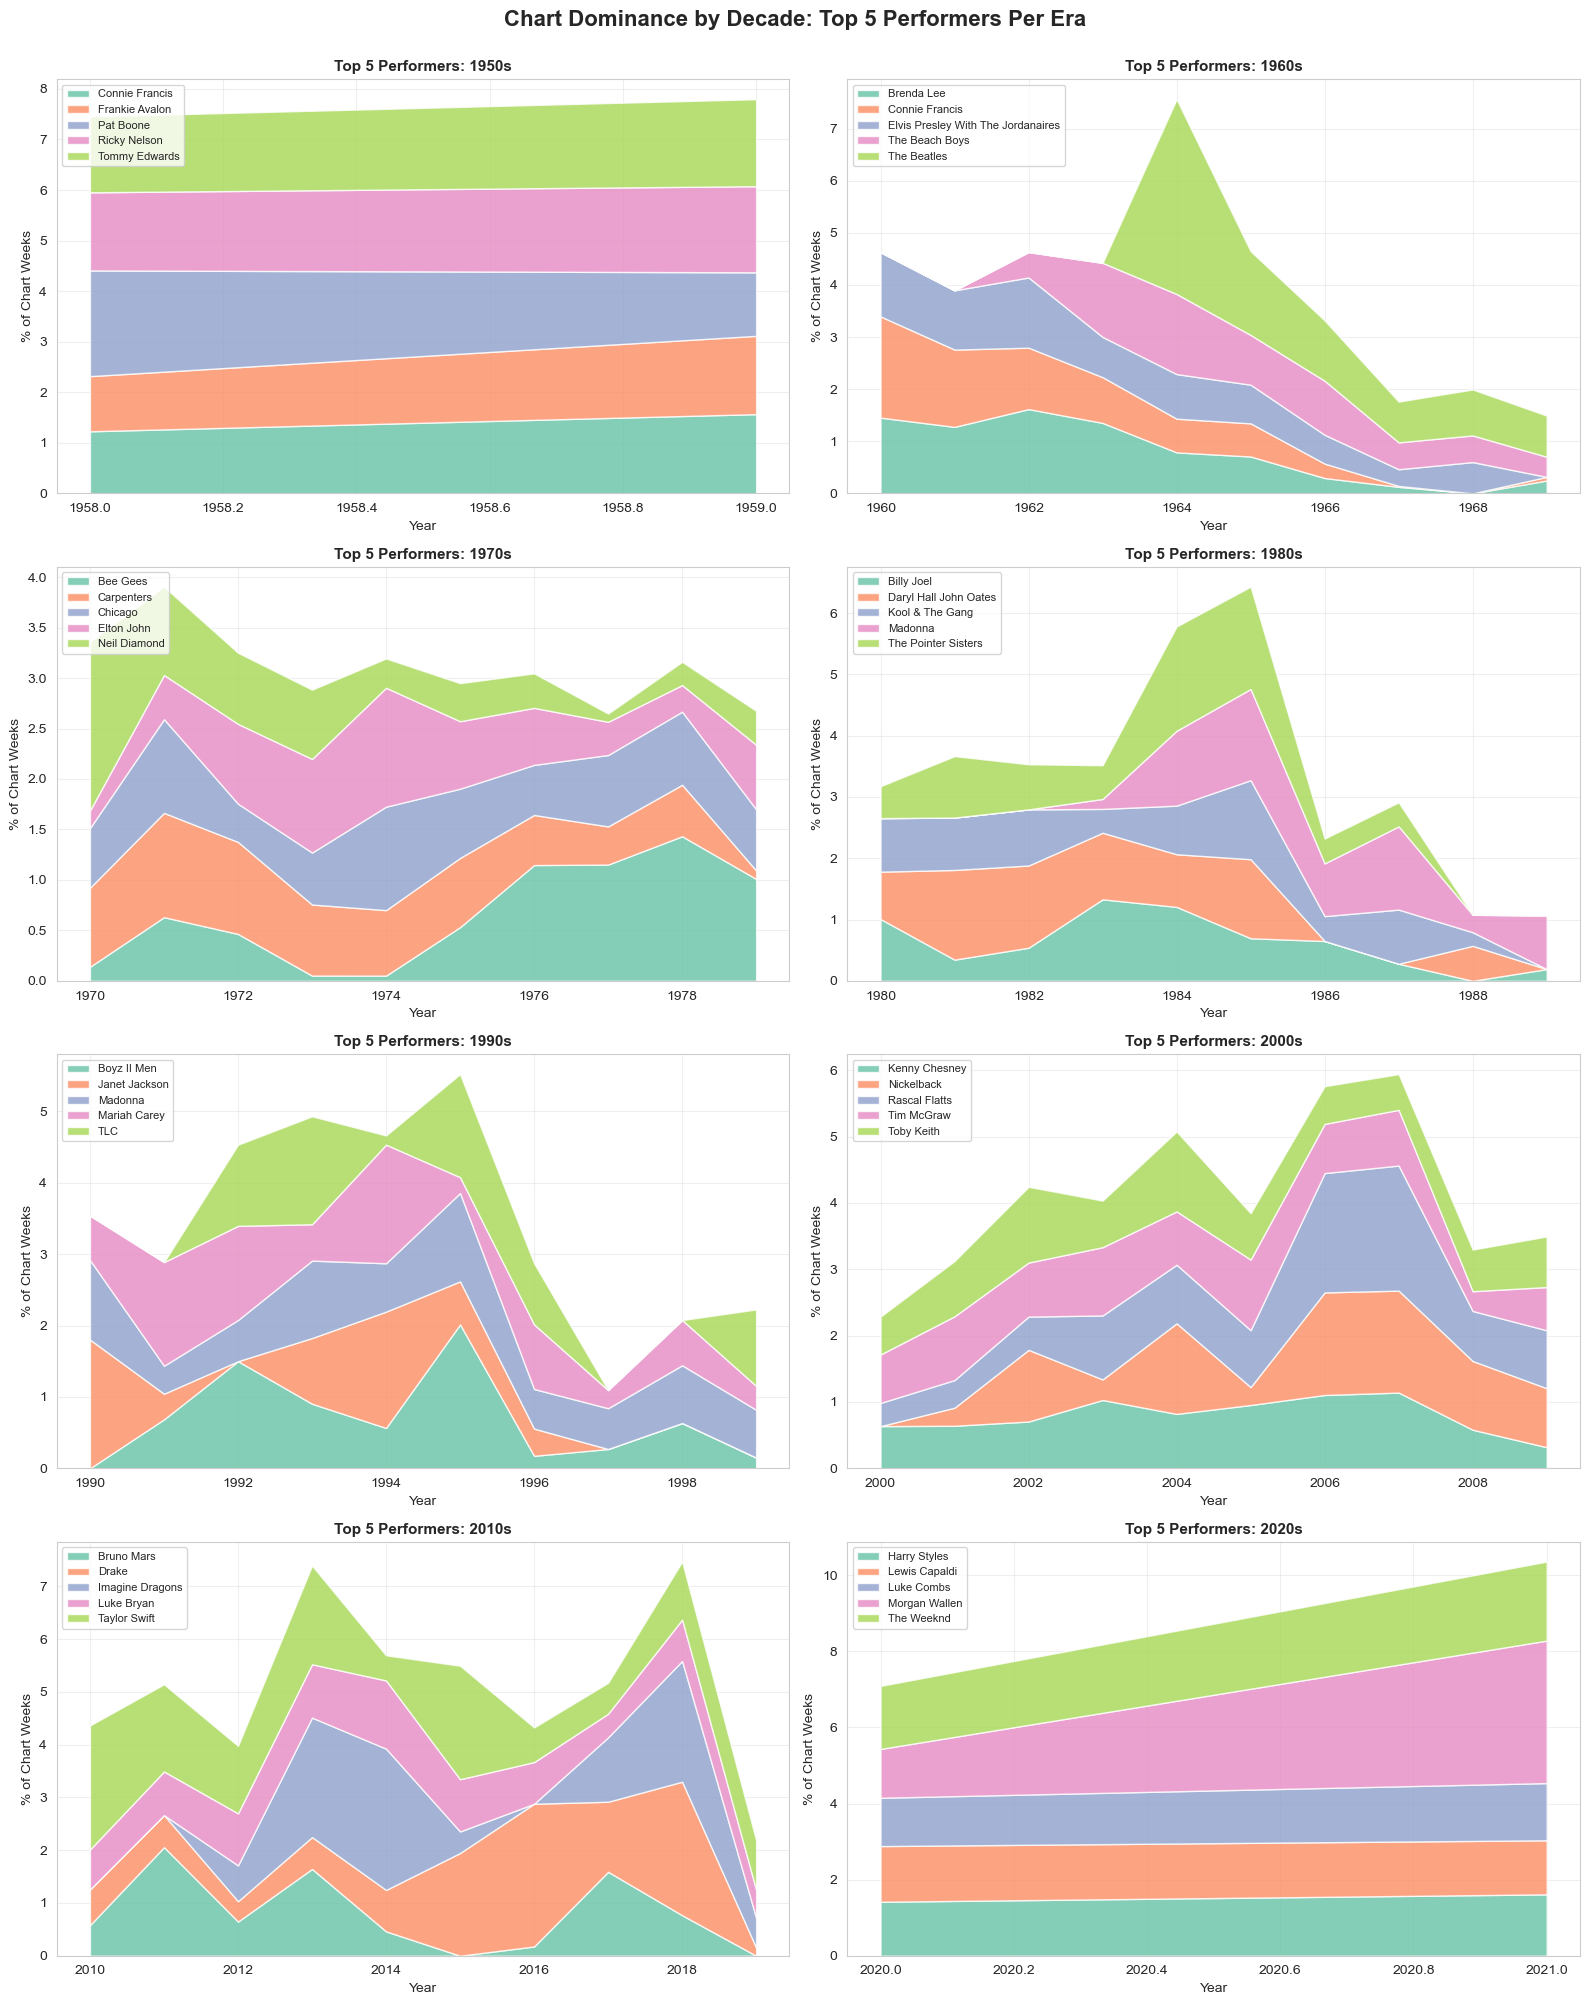

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
billboard['year'] = pd.to_datetime(billboard['week_id']).dt.year
billboard['decade'] = (billboard['year'] // 10) * 10
billboard['decade_label'] = billboard['decade'].astype(str) + 's'

decades = sorted(billboard['decade'].unique())

# Figure
n_decades = len(decades)
n_cols = 2
n_rows = (n_decades + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for idx, decade in enumerate(decades):
  decade_data = billboard[billboard['decade'] == decade]

  # Calculate weeks per performer in this decade
  decade_presence = decade_data.groupby(['performer', 'year', 'song_id']).agg({
      'weeks_on_chart': 'max'
  }).reset_index()

  performer_by_year = decade_presence.groupby(['performer', 'year'])[
      'weeks_on_chart'].sum().reset_index()

  # Get total weeks per year
  total_by_year = performer_by_year.groupby(
      'year')['weeks_on_chart'].sum().reset_index()
  total_by_year.columns = ['year', 'total_all_weeks']

  # Get top 5 performers for THIS decade
  decade_totals = performer_by_year.groupby(
      'performer')['weeks_on_chart'].sum().reset_index()
  top_5_decade = decade_totals.nlargest(5, 'weeks_on_chart')[
      'performer'].tolist()

  # Calculate market share
  top_performers_data = performer_by_year[performer_by_year['performer'].isin(
      top_5_decade)]
  top_by_year = top_performers_data.pivot(
      index='year', columns='performer', values='weeks_on_chart').fillna(0)
  top_by_year = top_by_year.merge(
      total_by_year, left_index=True, right_on='year')
  top_by_year.set_index('year', inplace=True)

  # Calculate percentages
  for performer in top_5_decade:
    if performer in top_by_year.columns:
      top_by_year[performer] = (
          top_by_year[performer] / top_by_year['total_all_weeks']) * 100

  top_by_year = top_by_year.drop('total_all_weeks', axis=1)

  # Plot stacked area for this decade
  axes[idx].stackplot(top_by_year.index,
                      *[top_by_year[col] for col in top_by_year.columns],
                      labels=top_by_year.columns,
                      alpha=0.8)

  axes[idx].set_xlabel('Year', fontsize=10)
  axes[idx].set_ylabel('% of Chart Weeks', fontsize=10)
  axes[idx].set_title(
      f'Top 5 Performers: {decade}s', fontsize=11, fontweight='bold')
  axes[idx].legend(loc='upper left', fontsize=8)
  axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(decades), len(axes)):
  axes[idx].set_visible(False)

# Display
fig.suptitle('Chart Dominance by Decade: Top 5 Performers Per Era',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

# Prepare data
num_hits_per_performer = billboard.groupby(
    'performer')['song_id'].nunique().reset_index()
num_hits_per_performer.columns = ['performer', 'num_hits']

# Calculate total weeks for hover info
song_weeks = billboard.groupby(['performer', 'song_id']).agg({
    'weeks_on_chart': 'max'
}).reset_index()
total_weeks_per_performer = song_weeks.groupby(
    'performer')['weeks_on_chart'].sum().reset_index()
total_weeks_per_performer.columns = ['performer', 'total_weeks']

# Merge the two metrics
performer_stats = num_hits_per_performer.merge(
    total_weeks_per_performer, on='performer')

# Get top 20 performers by number of hits
top_performers_hits = performer_stats.nlargest(
    20, 'num_hits').sort_values('num_hits')


# Figure
fig = px.bar(top_performers_hits,
             y='performer',
             x='num_hits',
             orientation='h',
             title='Top 20 Performers by Number of Chart Hits',
             labels={'num_hits': 'Number of Chart Hits',
                     'performer': 'Performer'},
             hover_data={'num_hits': True,
                         'total_weeks': True, 'performer': False},
             color='num_hits',
             color_continuous_scale='OrRd')

# Hover
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>' +
                  'Number of Hits: %{x}<br>' +
                  'Total Weeks on Chart: %{customdata[0]}<br>' +
                  '<extra></extra>'
)

# Display
fig.update_layout(
    height=700,
    xaxis_title='Number of Chart Hits',
    yaxis_title='',
    showlegend=False,
    font=dict(size=11)
)

fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Prepare data
song_weeks = billboard.groupby(['performer', 'song_id']).agg({
    'weeks_on_chart': 'max'
}).reset_index()

performer_stats = song_weeks.groupby('performer').agg({
    'weeks_on_chart': 'sum',
    'song_id': 'nunique'
}).reset_index()
performer_stats.columns = ['performer', 'total_weeks', 'num_songs']

top_performers = performer_stats.nlargest(
    20, 'total_weeks').sort_values('total_weeks')

# Figure
fig = px.bar(top_performers,
             y='performer',
             x='total_weeks',
             orientation='h',
             title='Top 20 Performers by Total Weeks on Chart',
             labels={'total_weeks': 'Total Weeks on Chart',
                     'performer': 'Performer'},
             hover_data={'total_weeks': True,
                         'num_songs': True, 'performer': False},
             color='total_weeks',
             color_continuous_scale='Tealgrn')

# Hover
fig.update_traces(
    hovertemplate='<b>%{y}</b><br>' +
                  'Total Weeks: %{x}<br>' +
                  'Number of Songs: %{customdata[0]}<br>' +
                  '<extra></extra>'
)

# Display
fig.update_layout(
    height=700,
    xaxis_title='Total Weeks on Chart',
    yaxis_title='',
    showlegend=False,
    font=dict(size=11)
)

fig.show()

In [ ]:
import plotly.express as px

# Prepare data
performer_metrics = billboard.groupby(['performer', 'song_id']).agg({
    'peak_position': 'min'
}).reset_index()

performer_summary = performer_metrics.groupby('performer').agg({
    'song_id': 'count',
    'peak_position': 'mean'
}).reset_index()
performer_summary.columns = ['performer', 'num_hits', 'avg_peak_position']

# Filter to performers with at least 3 hits to reduce noise
performer_summary = performer_summary[performer_summary['num_hits'] >= 3]

# Figure
fig = px.scatter(performer_summary,
                 x='num_hits',
                 y='avg_peak_position',
                 hover_data={'performer': True,
                             'num_hits': True,
                             'avg_peak_position': ':.1f'},
                 title='Performer Success Strategies: Quantity vs Quality',
                 labels={'num_hits': 'Number of Chart Hits',
                         'avg_peak_position': 'Average Peak Position (lower = better)'},
                 opacity=0.6,
                 color='avg_peak_position',
                 color_continuous_scale='RdYlGn_r')  # Red for worse, green for better

# Hover
fig.update_traces(
    hovertemplate='<b>%{customdata[0]}</b><br>' +
                  'Number of Hits: %{x}<br>' +
                  'Average Peak Position: %{y:.1f}<br>' +
                  '<extra></extra>',
    marker=dict(size=8)
)

# Invert y-axis so better positions (lower numbers) are at top
fig.update_yaxes(autorange='reversed')

# reference lines
fig.add_hline(y=10, line_dash="dash", line_color="gray",
              annotation_text="Top 10 average", annotation_position="right")

# Display
fig.update_layout(
    height=600,
    font=dict(size=11),
    hovermode='closest',
    showlegend=False
)

fig.show()

## Conclusions

### Summary of Key Findings

This analysis of over 327,000 Billboard Hot 100 chart entries spanning 1958-2021 reveals how fundamentally the music industry and chart dynamics have transformed, particularly in the streaming era.

#### 1. Chart Success is Highly Unequal

The distribution of chart longevity follows a classic "long tail" pattern - most songs have brief chart runs (median: [X] weeks) while a small number of mega-hits achieve extraordinary staying power (80+ weeks). This winner-take-most dynamic has only intensified over time.

#### 2. The Streaming Revolution Changed Everything

Around 2010, corresponding with the rise of Spotify, TikTok, and social media, we observe dramatic shifts:

- **"Climber" songs dropped from 75% to 20%** - Songs now debut with immediate impact rather than building gradually
- **Increased polarization** - Modern charts feature both flash-in-the-pan viral hits and unprecedented longevity for mega-hits
- **Songs got 32% shorter** since the 1990s peak, optimized for streaming economics and shrinking attention spans

#### 3. No Simple "Formula" for Success

Despite examining six audio features (energy, danceability, valence, tempo, loudness, acousticness), **none predict chart success** (all |r| < 0.06). This finding holds true in both the pre-2010 and post-2010 eras. Chart performance depends far more on:

- Marketing budgets and promotional strategies
- Artist reputation and existing fanbase
- Cultural timing and zeitgeist alignment
- Viral moments and algorithmic playlist placement
- The intangible "hit quality" that transcends measurable attributes

#### 4. Peak Position Drives Longevity

The strongest relationship we found: songs that peak higher stay on charts significantly longer (r = [correlation]). Chart success creates more success through increased exposure, radio play, and media attention - a self-reinforcing cycle that audio characteristics alone cannot predict.

#### 5. Genre Evolution Reflects Cultural Shifts

Popular genres have transformed across decades, from rock and soul dominance in the 1960s-70s to hip-hop and pop in the 2000s-2020s, mirroring broader cultural and demographic changes.

### Implications

**For Artists:** Success in the modern era requires optimizing for immediate impact - strong debuts matter more than slow builds. Song length, hooks, and social media virality are critical. However, the lack of an audio "formula" is encouraging - there's no single template to copy.

**For the Industry:** The data suggests streaming platforms and social media have created a more volatile, winner-take-all environment. While democratizing music distribution, these platforms may paradoxically concentrate success among viral phenomena.

**For Researchers:** The weak correlation between audio features and chart success suggests that cultural, social, and marketing factors dominate musical ones. Future research should incorporate social media metrics, marketing spend, and network effects.

### Limitations

1. **Incomplete Audio Data:** Only 9% of Billboard songs have Spotify audio features, potentially biasing analyses toward modern, Spotify-available music
2. **Billboard Methodology Changes:** Chart calculation methods have evolved (sales → radio → streaming), making cross-era comparisons imperfect
3. **Causality vs Correlation:** We observe relationships but cannot prove causation - does high energy cause success, or do successful songs happen to be high energy?
4. **Missing Variables:** We lack data on marketing budgets, social media engagement, radio play intensity, and other likely success drivers
5. **Survivorship Bias:** Songs that never charted don't appear in our dataset, limiting insights about what prevents chart entry

### Future Directions

Further research could explore:

- Integration of social media metrics (TikTok views, Twitter mentions, Instagram engagement)
- Analysis of marketing spend and promotional strategies
- Network effects and collaboration patterns among successful artists
- Genre-specific success factors and audio "formulas"
- Predictive modeling incorporating non-audio features
- Comparative analysis across different streaming platforms (Spotify, Apple Music, YouTube)

### Final Thought

The transformation from gradual "climbers" building momentum through radio play to instant viral sensations reflects not just technological change, but a fundamental restructuring of how culture spreads. In the streaming era, music discovery is algorithmic, attention is fragmented, and success is increasingly binary - you're either a viral phenomenon or invisible. The democratization of distribution hasn't eliminated gatekeepers; it's simply rep
